# Ambulance Trusts

## 1 Summary

**Aim:** Add ambulance trust to each LSOA in collated_data.csv

Note: For source of images, see 'images/image_sources.txt'.

## 2 Import packages and set file paths

In [1]:
# Import required packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    image = './external_images'
    aace = 'aace-map-all.png'
    pollitt = 'pollitt-map.png'
    hsi_ccg = 'hampshire_southampton_isleofwight_ccg.png'
    scas = 'SCAS-map.png'
    eeas = 'our-station-map.jpg'
    blmk = 'BLMK_Map.png'

    data = './data'
    collated = 'collated_data.csv'
    collated_amb = 'collated_data_amb.csv'

    look_ups = 'look_ups'
    lsoa_to_lad = ('LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District' +
                   '_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
    lad_to_country = ('Local_Authority_District_to_Country_(December_2022)' +
                      '_Lookup_in_the_United_Kingdom.csv')
    lsoa_to_ccg = ('Lower_Layer_Super_Output_Area_(2011)_to_Clinical_' +
                   'Commissioning_Group_to_Local_Authority_District_(April_' +
                   '2021)_Lookup_in_England.csv')

    demographic = 'demographic'
    ccg_to_amb = 'ambulance_service_info_ccg_lookup.csv'


paths = Paths()

## 3 Background

### 3.1 Existing maps of ambulance boundaries

The Association of Ambulance Chief Executives provide an interactive map [on their website](https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/) (screenshot copied below) that shows the ambulance boundaries. We have been advised by Steve Irving (Executive Officer / ALF Conference Lead) that the map "is just an approximation of the boundaries, purely for illustrative / navigational purposes".

In England and Wales, there are 12 ambulance services:
1. East Midlands Ambulance Service (EMAS)
2. East of England Ambulance Service Trust (EEAST)
3. London Ambulance Service (LAS)
4. North East Ambulance Service (NEAS)
5. North West Ambulance Service (NWAS)
6. South Central Ambulance Service (SCAS)
7. South East Coast Ambulance Service (SECAmb)
8. West Midlands Ambulance Service (WMAS)
9. South West Ambulance Service (SWAS)
10. Yorkshire Ambulance Service (YAS)
11. Welsh Ambulance Service (WAS)
12. Isle of Wight Ambulance Service

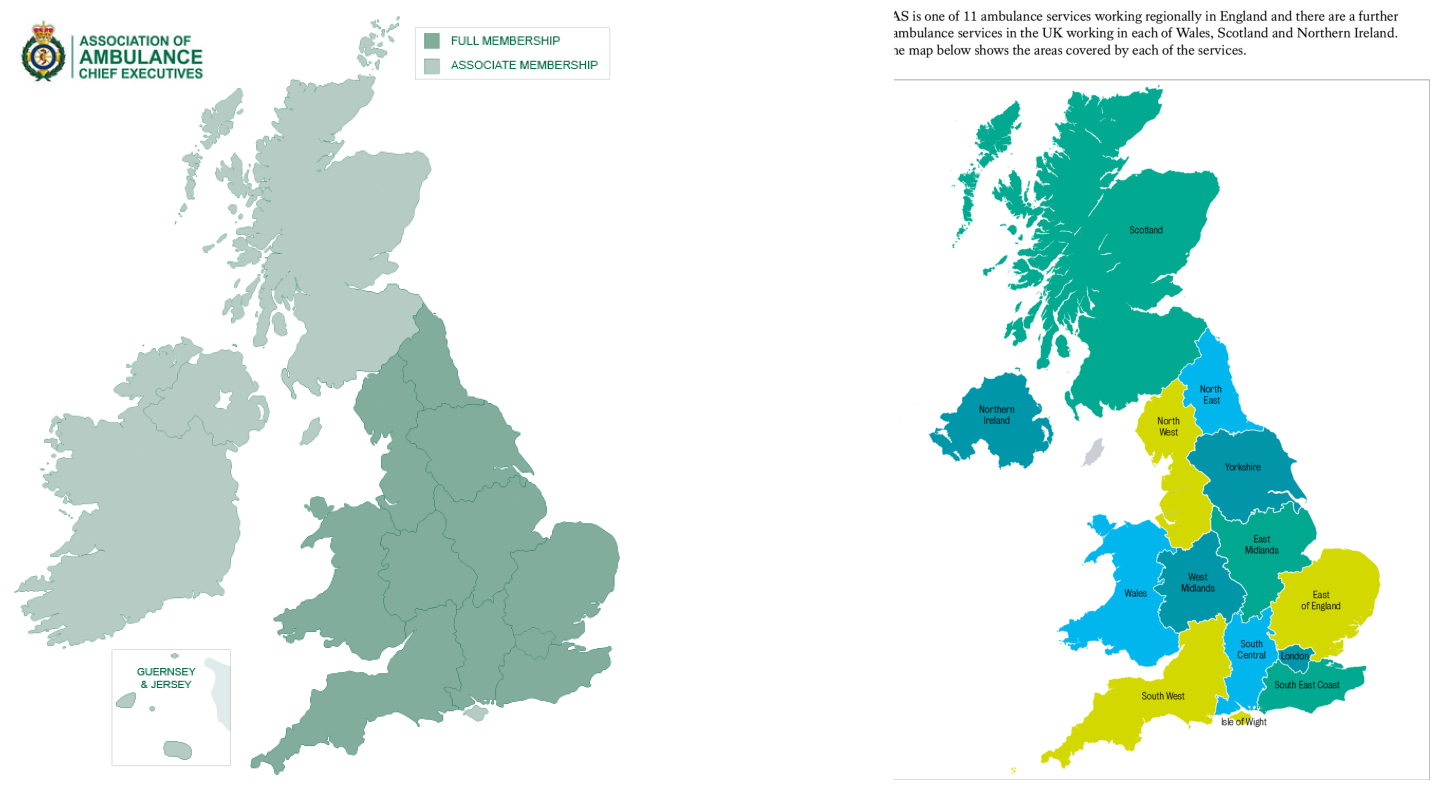

In [3]:
# Display images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.aace))))
axs[0].axis('off')
axs[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.pollitt))))
axs[1].axis('off')
plt.show()

### 3.2 Existing spreadsheets which identify ambulance boundaries

We can link together two dataframes that take us from **LSOA to CCG** and then **CCG to Ambulance Service**. The second file, `ambulance_service_info_ccg_lookup.csv`, was created from ambulance_service_info.xlsx, with the removal of the two CCGs with complications (which did not have data in the file and just said "More than one" in the ambulance service columns.)

There are **three complications**, which are explained in more detail in their sections of the notebook below:
* NHS Hampshire, Southampton, and Isle of Wight CCG is covered by two different ambulance services
* NHS Bedfordshire, Luton and Milton Keynes CCG is covered by two different ambulance services
* Wales is not included in the spreadsheet

## 4 Create LSOA to Ambulance Service based on lookup files

Load file with LSOA to CCG

In [4]:
# Load the LSOA to CCG look-up
lsoa_ccg_data = pd.read_csv(
    os.path.join(paths.data, paths.look_ups, paths.lsoa_to_ccg),
    index_col='CCG21NM')

lsoa_ccg_data.head(2)

,FID,LSOA11CD,LSOA11NM,CCG21CD,CCG21CDH,LAD21CD,LAD21NM
CCG21NM,,,,,,,
NHS Barnsley CCG,1,E01007420,Barnsley 016C,E38000006,02P,E08000016,Barnsley
NHS Barnsley CCG,2,E01007317,Barnsley 018A,E38000006,02P,E08000016,Barnsley


Load file with CCG to ambulance trust

In [5]:
# Load the CCG to ambulance look-up
ccg_amb_data = pd.read_csv(
    os.path.join(paths.data, paths.look_ups, paths.ccg_to_amb),
    index_col='CCG name')

# Remove trailing whitespace from column names
ccg_amb_data.columns = ccg_amb_data.columns.str.rstrip()

# Preview dataframe
ccg_amb_data.head(2)

,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code
CCG name,,,,,,
NHS Bassetlaw CCG,02Q,E38000008,EMAS,Midlands,Y60,E40000008
NHS East Leicestershire and Rutland CCG,03W,E38000051,EMAS,Midlands,Y60,E40000008


Add column with unique, full name for each ambulance service to the CCG to Ambulance file

In [6]:
# Create dictionary with guide to full ambulance service names
dict_amb_service_name = {'EMAS': 'East Midlands',
                         'EEAST': 'East of England',
                         'LAS': 'London',
                         'NEAS': 'North East',
                         'NWAS': 'North West',
                         'SCAS': 'South Central',
                         'SECAmb': 'South East Coast',
                         'WMAS': 'West Midlands',
                         'SWAS': 'South West',
                         'YAS': 'Yorkshire'}

# Add full ambulance service name, based on the data dictionary
ccg_amb_data['Ambulance Service Name'] = (
    ccg_amb_data['Ambulance Service'].map(dict_amb_service_name))

# Preview dataframe
ccg_amb_data.head(2)

,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code,Ambulance Service Name
CCG name,,,,,,,
NHS Bassetlaw CCG,02Q,E38000008,EMAS,Midlands,Y60,E40000008,East Midlands
NHS East Leicestershire and Rutland CCG,03W,E38000051,EMAS,Midlands,Y60,E40000008,East Midlands


Add the CCG to Ambulance fields to the LSOA to CCG dataset (by matching on CCG name - make that the index for both datasets before joining)

In [7]:
# Join LSOA-CCG and CCG-Ambulance based on index (which is the CCG name)
lsoa_amb_data = lsoa_ccg_data.join(ccg_amb_data).reset_index()

# Set dataframe index to LSOA
lsoa_amb_data.set_index('LSOA11CD', inplace=True)

# Preview dataframe
lsoa_amb_data.head(2)

,CCG21NM,FID,LSOA11NM,CCG21CD,CCG21CDH,LAD21CD,LAD21NM,NHS CCG code,Office for National Statistics (ONS) April 2021 CCG code,Ambulance Service,NHS Ambulance Service Region Name,NHS Ambulance Service Region code,ONS Ambulance Service Region Code,Ambulance Service Name
LSOA11CD,,,,,,,,,,,,,,
E01007420,NHS Barnsley CCG,1,Barnsley 016C,E38000006,02P,E08000016,Barnsley,02P,E38000006,YAS,North East and Yorkshire,Y63,E40000009,Yorkshire
E01007317,NHS Barnsley CCG,2,Barnsley 018A,E38000006,02P,E08000016,Barnsley,02P,E38000006,YAS,North East and Yorkshire,Y63,E40000009,Yorkshire


## 5 Add NHS Hampshire, Southampton and Isle of Wight CCG

### 5.1 Maps

As you can see from the maps, this CCG includes areas from Hampshire and Isle of Wight (and does not, for example, include Portsmouth or North East Hampshire, which are part of different CCGs).

Of the areas in the CCG:
* The **South Central Ambulance Service** (SCAS) covers Hampshire
* The **Isle of Wight Ambulance Service** covers the Isle of Wight


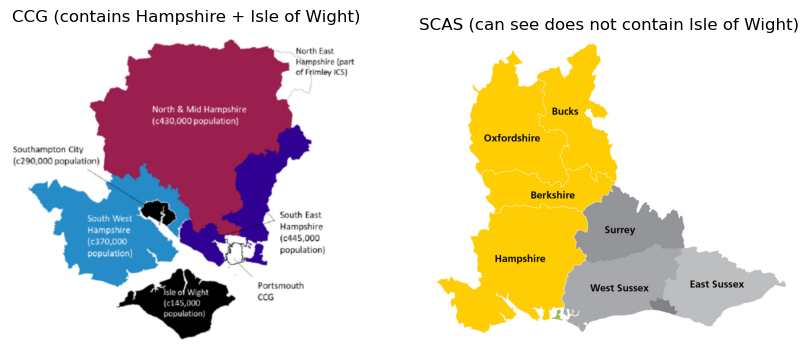

In [8]:
# Display images side-by-side
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ax[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.hsi_ccg))))
ax[0].axis('off')
ax[0].set_title('CCG (contains Hampshire + Isle of Wight)')
ax[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.scas))))
ax[1].axis('off')
ax[1].set_title('SCAS (can see does not contain Isle of Wight)')
plt.show()

### 5.2 Add appropriate service to each LSOA

Assign LSOAs in Isle of Wight to the Isle of Wight Ambulance Service. Assign the remaining LSOAs to the South Central Ambulance Service.

In [9]:
# Find LSOAs in that CCG
mask = lsoa_amb_data['CCG21NM'].str.contains('Hampshire')

# Set the ambulance service as South Central (SCAS)
lsoa_amb_data.loc[mask, 'Ambulance Service Name'] = 'South Central'

# From those LSOAs, identify those that are in the Isle of Wight
mask2 = lsoa_amb_data['LSOA11NM'].str.contains('Isle of Wight')

# Replace the ambulance service for those to Isle of Wight
lsoa_amb_data.loc[mask2, 'Ambulance Service Name'] = 'Isle of Wight'

# View resulting number of LSOA from that CCG in each service
lsoa_amb_data.loc[mask, 'Ambulance Service Name'].value_counts()

Ambulance Service Name
South Central    879
Isle of Wight     89
Name: count, dtype: int64

## 6 Add NHS Bedfordshire, Luton and Milton Keynes CCG

### 6.1 Maps and information about the area

This CCG contains:

| Local authority | County |
| --- | --- |
| Central Bedfordshire | Bedfordshire |
| Luton | Bedfordshire |
| Bedford | Bedfordshire |
| Milton Keynes | Buckinghamshire |
| Buckinghamshire | Buckinghamshire |

In [10]:
lsoa_ccg_data.loc[
    'NHS Bedfordshire, Luton and Milton Keynes CCG', 'LAD21NM'].value_counts()

LAD21NM
Central Bedfordshire    157
Milton Keynes           152
Luton                   121
Bedford                 103
Buckinghamshire           4
Name: count, dtype: int64

It is covered by two ambulance services: (1) East of England Ambulance Service, and (2) South Central Ambulance Service. 

To deal with this:

* LSOAs in Bedfordshire were assigned to East of England Ambulance Service
* LSOAs in Buckinghamshire were assigned to South Central Ambulance Service

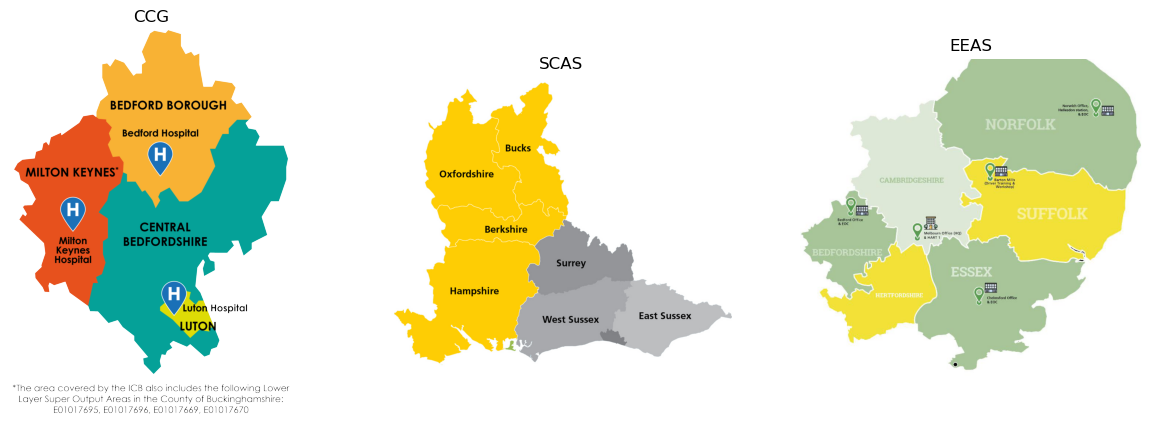

In [11]:
# Display images side-by-side
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
ax[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.blmk))))
ax[0].axis('off')
ax[0].set_title('CCG')
ax[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.scas))))
ax[1].axis('off')
ax[1].set_title('SCAS')
ax[2].imshow(np.array(Image.open(os.path.join(paths.image, paths.eeas))))
ax[2].axis('off')
ax[2].set_title('EEAS')
plt.show()

### 6.2 Add appropriate services based on county

In [12]:
# Identify LSOAs from the CCG in Bedfordshire
bed_mask = ((lsoa_amb_data['CCG21NM'] ==
             'NHS Bedfordshire, Luton and Milton Keynes CCG') &
            (lsoa_amb_data['LAD21NM'].isin([
                'Central Bedfordshire', 'Luton', 'Bedford'])))

# Set ambulance service to East of England
lsoa_amb_data.loc[bed_mask, 'Ambulance Service Name'] = 'East of England'

In [13]:
# Identify LSOAs from the CCG in Buckinghamshire
buc_mask = ((lsoa_amb_data['CCG21NM'] ==
             'NHS Bedfordshire, Luton and Milton Keynes CCG') &
            (lsoa_amb_data['LAD21NM'].isin([
                'Milton Keynes', 'Buckinghamshire'])))

# Set ambulance service to South Central
lsoa_amb_data.loc[buc_mask, 'Ambulance Service Name'] = 'South Central'

## 7 Add services to collated_data.csv

In [14]:
# Import collated data
collated = pd.read_csv(os.path.join(paths.data, paths.collated),
                       index_col='LSOA')
collated.head(2)

,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,imd_2019_score,...,age_band_males_45,age_band_males_50,age_band_males_55,age_band_males_60,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90
LSOA,,,,,,,,,,,,,,,,,,,,,
Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,15.616,...,47,66,59,28,33,28,26,14,5,3
Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,33.313,...,62,60,80,53,24,18,21,12,5,4


In [15]:
# Filter, rename and reindex lsoa_amb_data so ready to join
lsoa_amb = (lsoa_amb_data
            .reset_index()
            .set_index('LSOA11NM')
            .rename(columns={'Ambulance Service Name': 'ambulance_service'}))
lsoa_amb = lsoa_amb['ambulance_service']
lsoa_amb.head(2)

LSOA11NM
Barnsley 016C    Yorkshire
Barnsley 018A    Yorkshire
Name: ambulance_service, dtype: object

In [16]:
# Join ambulance services to collated data based on index (LSOA)
collated_amb = collated.join(lsoa_amb)

## 8 Add Wales to collated_data.csv

Wales was not included in the lookup files used to create LSOA_amb_data. Wales is covered by a single ambulance service.

Add local authority district to collated data

In [17]:
# Import file with LSOA to Local Authority for England and Wales
lsoa_lad = pd.read_csv(
    os.path.join(paths.data, paths.look_ups, paths.lsoa_to_lad),
    index_col='LSOA11NM')

# Add local authority district to collated data
lsoa_lad = lsoa_lad.rename(columns={'LAD22NM': 'local_authority_district_22'})
collated_amb = collated_amb.join(lsoa_lad['local_authority_district_22'])

# Preview dataframe
collated_amb.head(2)

,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,imd_2019_score,...,age_band_males_55,age_band_males_60,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90,ambulance_service,local_authority_district_22
LSOA,,,,,,,,,,,,,,,,,,,,,
Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,15.616,...,59,28,33,28,26,14,5,3,East of England,Welwyn Hatfield
Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,33.313,...,80,53,24,18,21,12,5,4,East of England,Welwyn Hatfield


Add country to collated data

In [18]:
# Import file with Local Authority to Country
lad_country = pd.read_csv(
    os.path.join(paths.data, paths.look_ups, paths.lad_to_country))

# Rename country
lad_country = lad_country.rename(columns={'CTRY22NM': 'country'})

# Merge with collated_amb
collated_amb = (collated_amb
                .reset_index()
                .merge(lad_country[['LAD22NM', 'country']],
                       how='left',
                       left_on='local_authority_district_22',
                       right_on='LAD22NM',)
                .set_index('LSOA'))

# Preview dataframe
collated_amb.head(2)

,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,imd_2019_score,...,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90,ambulance_service,local_authority_district_22,LAD22NM,country
LSOA,,,,,,,,,,,,,,,,,,,,,
Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,15.616,...,33,28,26,14,5,3,East of England,Welwyn Hatfield,Welwyn Hatfield,England
Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,33.313,...,24,18,21,12,5,4,East of England,Welwyn Hatfield,Welwyn Hatfield,England


Set ambulance service to Wales to all LSOA in Wales

In [19]:
# Find LSOA in Wales and set ambulance service to Welsh
mask = collated_amb['country'] == 'Wales'
collated_amb.loc[mask, 'ambulance_service'] = 'Welsh'

# Preview dataframe
collated_amb.head(2)

,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,imd_2019_score,...,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90,ambulance_service,local_authority_district_22,LAD22NM,country
LSOA,,,,,,,,,,,,,,,,,,,,,
Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,15.616,...,33,28,26,14,5,3,East of England,Welwyn Hatfield,Welwyn Hatfield,England
Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,33.313,...,24,18,21,12,5,4,East of England,Welwyn Hatfield,Welwyn Hatfield,England


## 9 Save file

Check all LSOA have an ambulance service

In [20]:
collated_amb['ambulance_service'].value_counts(dropna=False)

ambulance_service
London              4835
North West          4521
East of England     3623
West Midlands       3487
South West          3284
South East Coast    3118
Yorkshire           3107
East Midlands       2951
South Central       2171
Welsh               1909
North East          1657
Isle of Wight         89
Name: count, dtype: int64

Save as csv

In [21]:
collated_amb.to_csv(
    os.path.join(paths.data, paths.collated_amb), index_label='LSOA')